In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [21]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

old_seen = pd.read_csv('../data/category_predictions.csv')
common_columns = [x for x in seen_df.columns if x in old_seen.columns]
old_seen = old_seen[(old_seen['seen']==1) & (~old_seen['id'].isin(seen_df['id']))][common_columns]

seen_df = pd.concat([seen_df, old_seen])

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)
     



seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

len(seen_index)

2349

In [22]:
from alterations import postfix_data
df = postfix_data(df)

In [23]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2349, 20000)

In [24]:
broad_cats = [x for x in df.columns if "12 - " in x and "Physical systems" not in x and "prediction" not in x]
broad_cats

['12 - Coastal and marine Ecosystems',
 '12 - Human and managed',
 '12 - Mountains, snow and ice',
 '12 - Rivers, lakes, and soil moisture',
 '12 - Terrestrial ES']

In [25]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[broad_cats])
print(y.shape)

multimodels = [ 
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },     
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, rel_index, n_splits=10, classes=broad_cats, df = df)


(2349, 5)
1
2
3
4
5
6
7
8
9
10


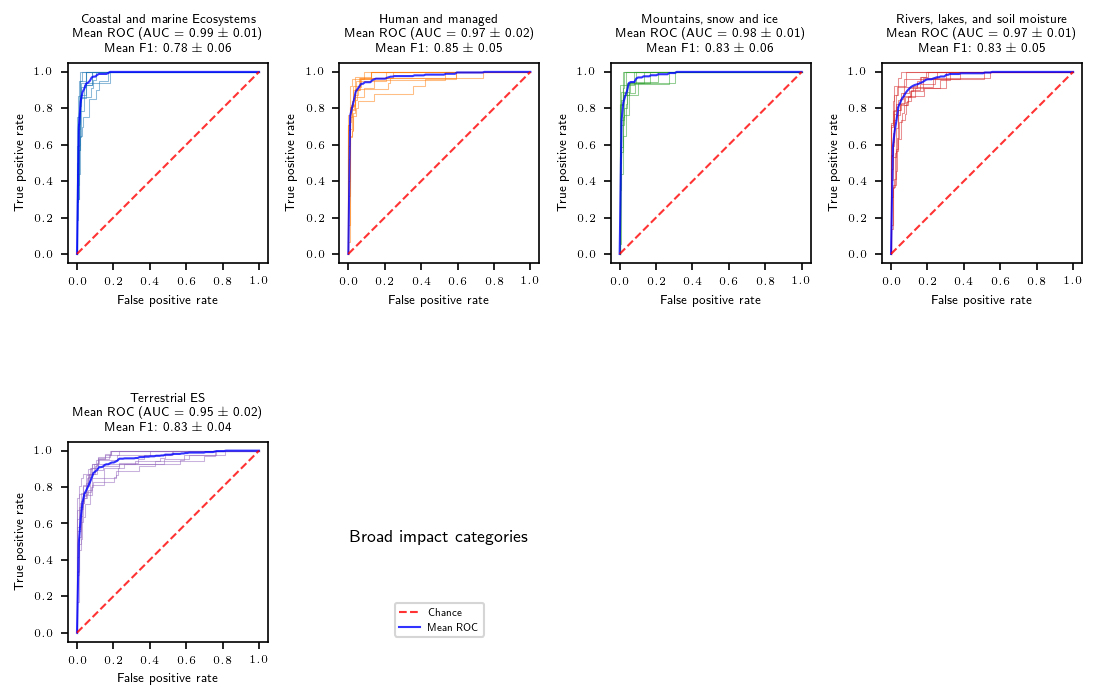

In [133]:
from scipy import interp
import matplotlib.gridspec as gridspec
model = multimodels_ar5[0]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 6
})

fig = plt.figure(dpi=150,figsize=(7.2,5), constrained_layout=True)

ncols = 4

gs = gridspec.GridSpec(2, ncols, figure=fig)

def mean_roc_auc_plot(model, c, ax):
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = np.mean(model[f'auc\n{c}'])
    std_auc = np.std(model[f'auc\n{c}'])
    
    mean_f1 = np.mean(model[f'f1\n{c}'])
    std_f1 = np.std(model[f'f1\n{c}'])
    
    tprs = []
    for i in range(len(model['i'])):
        viz = ax.plot(
            model[f'fpr\n{c}'][i],
            model[f'tpr\n{c}'][i],
            lw=0.5,
            alpha=0.5,
            color=f"C{j}"
        )

        interp_tpr = interp(mean_fpr, model[f'fpr\n{c}'][i], model[f'tpr\n{c}'][i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
    ax.plot(
        mean_fpr, mean_tpr, color='b',
        label=label,
        lw=1, alpha=.8
    )
    
    title = c.split(" - ")[1].replace('&','\&').split('(')[0].replace('2.5. ','').replace('2.4. ','')
    
    f1_label = r'%0.2f $\pm$ %0.2f' % (mean_f1, std_f1)
    
    ax.set_title(f"{title}\n{label}\nMean F1: {f1_label}", fontsize=6)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
        label='Chance', alpha=.8)

    #ax.legend(fontsize=5)
    ax.set_aspect("equal")
    
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    
def blank_roc_auc_plot(ax, title):
    ax.plot([], [], linestyle='--', lw=1, color='r',
            label='Chance', alpha=.8)
    ax.plot(
            [],[], color='b',
            label="Mean ROC",
            lw=1, alpha=.8,
        )
    ax.text(0.5,0.5, title, ha="center", fontsize=8)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.axis('off')
    ax.set_aspect("equal")
    ax.legend(fontsize=5, loc="lower center")
    

for j,c in enumerate(broad_cats):
    ax = plt.subplot(gs[j//ncols,j%ncols])
    mean_roc_auc_plot(model, c, ax)
    
j+=1
ax = plt.subplot(gs[j//ncols,j%ncols])

blank_roc_auc_plot(ax, "Broad impact categories")



            
plt.savefig('../figures/si_figure_3.pdf', bbox_inches="tight")
plt.savefig('../figures/si_figure_3.png', bbox_inches="tight")

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


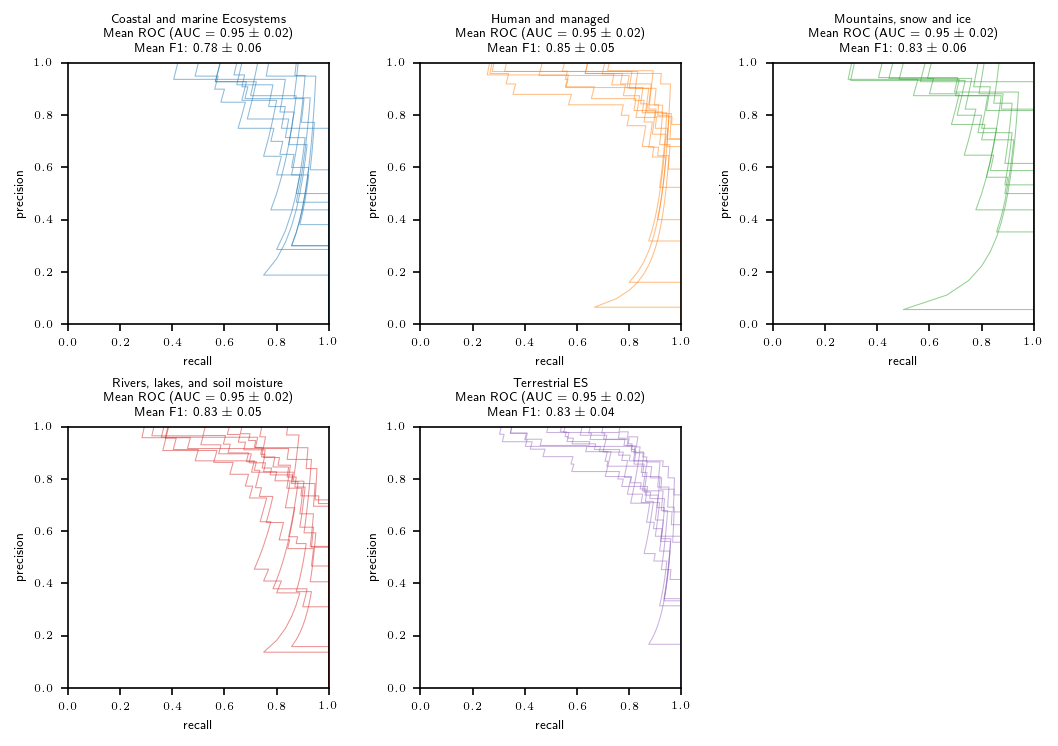

In [132]:
from scipy import interp
import matplotlib.gridspec as gridspec
model = multimodels_ar5[0]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 6
})

fig = plt.figure(dpi=150,figsize=(7.2,5), constrained_layout=True)

gs = gridspec.GridSpec(2, 3, figure=fig)

for j,c in enumerate(broad_cats):
    ax = plt.subplot(gs[j//3,j%3])
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = np.mean(model[f'auc\n{c}'])
    std_auc = np.std(model[f'auc\n{c}'])
    
    mean_f1 = np.mean(model[f'f1\n{c}'])
    std_f1 = np.std(model[f'f1\n{c}'])
    
    tprs = []
    for i in range(len(model['i'])):
        viz = ax.plot(
            model[f'prec\n{c}'][i],
            model[f'rec\n{c}'][i],
            lw=0.5,
            alpha=0.5,
            color=f"C{j}"
        )
    
    title = c.split(" - ")[1].split('(')[0]
    
    
    
    f1_label = r'%0.2f $\pm$ %0.2f' % (mean_f1, std_f1)
    
    ax.set_title(f"{title}\n{label}\nMean F1: {f1_label}", fontsize=6)

    ax.set_aspect("equal")

    ax.set_ylabel('precision')
    ax.set_ylim((0,1))
    ax.set_xlim((0,1))
    ax.set_xlabel('recall')
            
fig.tight_layout()

## Attribution prediction

In [51]:
df['2 - Trend or climate change attribution'] = 0
df.loc[
    (df['2 - 2.2 Trend attribution']==1) | (df['2 - 2.1. Climate change attribution']==1),
    '2 - Trend or climate change attribution'
] = 1

attribution_classes =  [
 '2 - Trend or climate change attribution',
 '2 - 2.4. Sensitivity',
 '2 - 2.5. Detection of a regional climate trend (no attribution)'
]

y = np.matrix(df[attribution_classes])


new_rel_index = physical_index.intersection(rel_index)
print(new_rel_index)
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },    
]


attribution_models, attribution_metrics, df = lu.cross_validate_models(
    X, y, multimodels, new_rel_index, n_splits=10, classes=attribution_classes, df =df,
    roundup=True
)


Int64Index([   4,    9,   11,   13,   14,   15,   18,   19,   21,   24,
            ...
            2329, 2331, 2333, 2335, 2339, 2340, 2342, 2343, 2344, 2346],
           dtype='int64', length=900)
(2349, 3)
1
2
3
4
5
6
7
8
9
10


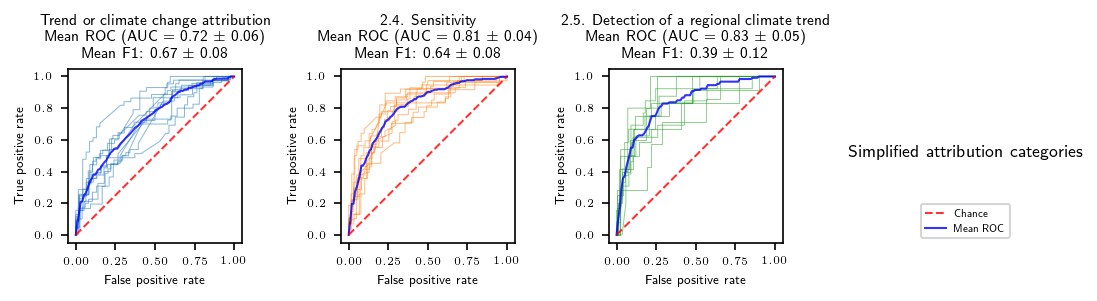

In [113]:
from scipy import interp
import matplotlib.gridspec as gridspec
model = attribution_models[0]

fig = plt.figure(dpi=150,figsize=(7.2,5), constrained_layout=True)

ncols = 4

gs = gridspec.GridSpec(1, ncols, figure=fig)

for j,c in enumerate(attribution_classes):
    ax = plt.subplot(gs[j//ncols,j%ncols])
    mean_roc_auc_plot(model, c, ax)
    
j+=1
ax = plt.subplot(gs[j//ncols,j%ncols])
blank_roc_auc_plot(ax, "Simplified attribution categories")
            
plt.savefig('../figures/si_figure_4.pdf', bbox_inches="tight")
plt.savefig('../figures/si_figure_4.png', bbox_inches="tight")

In [53]:
## New summary cats
df['6 - Precipitation'] = 0
df.loc[(df['6 - 05 Changes in precipitation']==1) | (df['6 - 08 Changes in strong precipitation']==1),"6 - Precipitation"] = 1

df['Human drivers'] = 0
df.loc[
    (df['6 - 76 Human water use']==1) |
    (df['6 - 77 Land use change']==1),
    '6 - Human drivers' 
] = 1
 
df.loc[
    (df['6 - 03 Extreme temperature']==1) & 
    (df['6 - 16 Sea surface temperature']==0) & 
    (df['6 - 21 Water temperature (freshwater)']==0),
    '6 - 02 Air or land surface temperature changes'
] = 1

df['6 - Temperature'] = 0
df.loc[
    (df['6 - 03 Extreme temperature']==1) | 
    (df['6 - 16 Sea surface temperature']==1) | 
    (df['6 - 02 Air or land surface temperature changes']==1) |
    (df['6 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1

df['6 - Water availability'] = 0
df.loc[
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 07 Aridity/dryness']==1) |
    (df['6 - 28 River runoff']==1),
    '6 - Water availability'
] = 1

df['6 - Other'] = 0
df.loc[
    (df['6 - Temperature']==0) & 
    (df['6 - Precipitation']==0),
    '6 - Other'
] = 1

new_rel_index = physical_index.intersection(rel_index)

driver_selection = [
    #'6 - 01 CO2 concentration',
    '6 - Temperature',
    '6 - Precipitation',#'6 - 16 Sea surface temperature',
    '6 - Other'
    #'6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    #'6 - No drivers', '6 - 30 Snow', '6 - Human drivers', 
    #'6 - 12 Seasonality',
    #'6 - Water availability',
]

In [58]:
classes = driver_selection

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

import scoping.utils.learning_utils as lu

from importlib import reload  
#reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced lin', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers_few, metrics, df = lu.cross_validate_models(
    X, y, multimodels, new_rel_index, n_splits=10, classes=classes, df = df,
    roundup=True
)

(2349, 3)
1
2
3
4
5
6
7
8
9
10


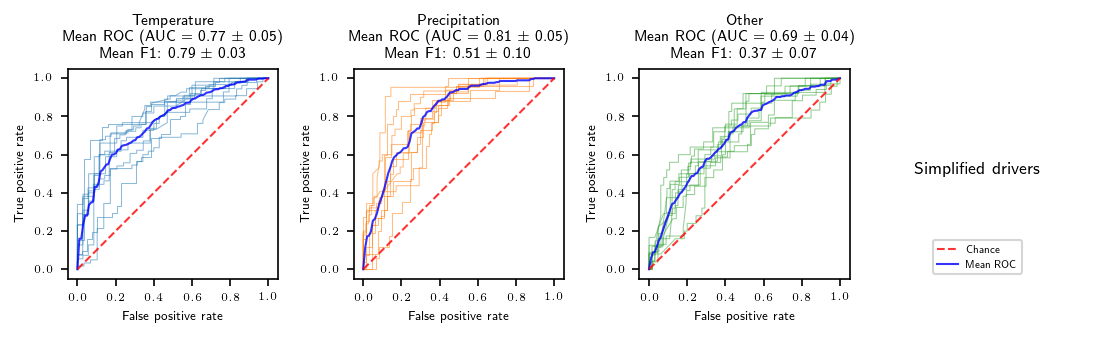

In [104]:
from scipy import interp
import matplotlib.gridspec as gridspec
model = multimodels_drivers_few[0]

fig = plt.figure(dpi=150,figsize=(7.2,6), constrained_layout=True)

ncols=4

gs = gridspec.GridSpec(1, ncols, figure=fig)

for j,c in enumerate(driver_selection):
    ax = plt.subplot(gs[j//ncols,j%ncols])
    mean_roc_auc_plot(model, c, ax)
    
j+=1
ax = plt.subplot(gs[j//ncols,j%ncols])

blank_roc_auc_plot(ax, "Simplified drivers")
            
# plt.savefig('../figures/si_figure_5.pdf', bbox_inches="tight")
# plt.savefig('../figures/si_figure_5.png', bbox_inches="tight")

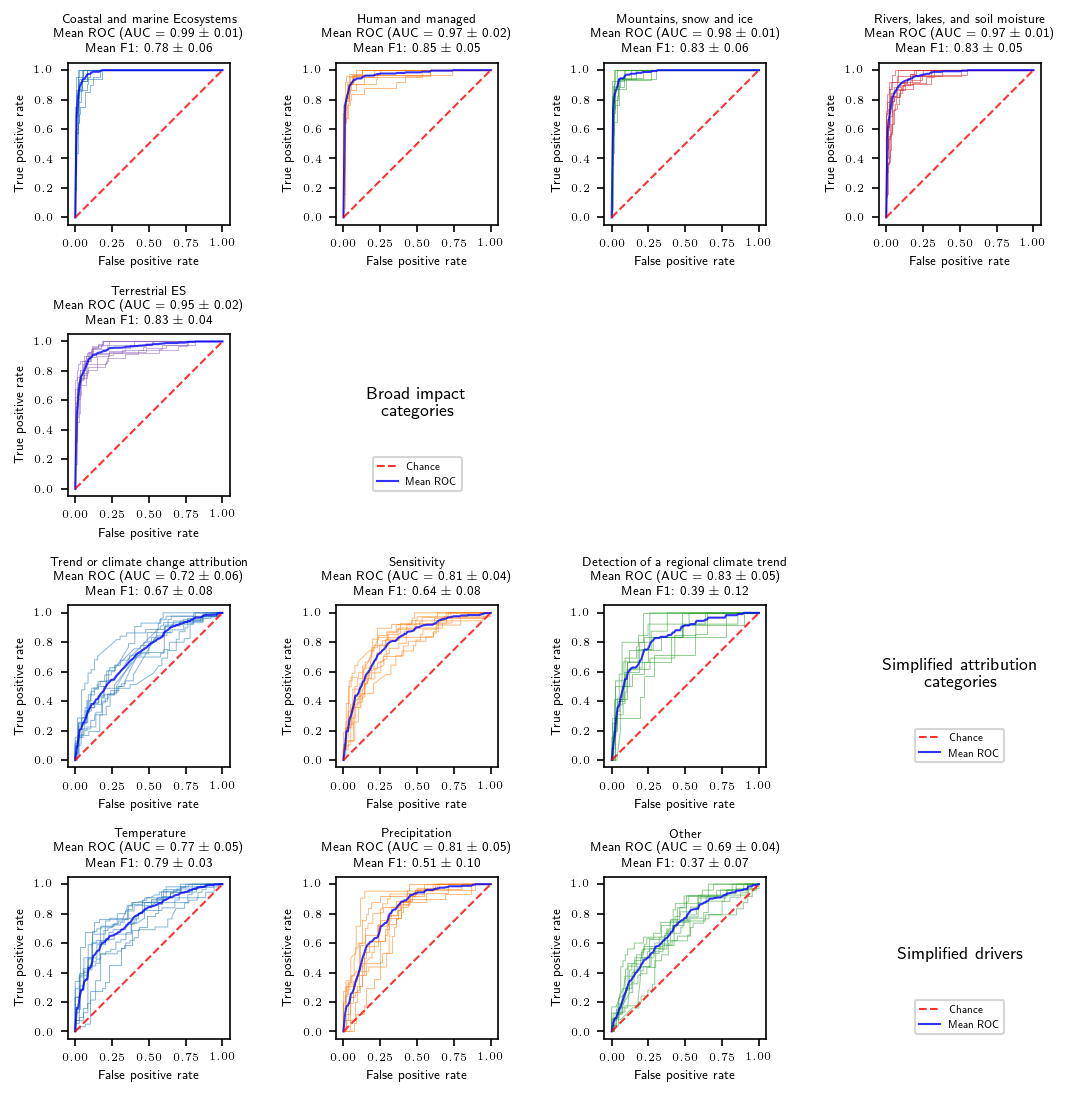

In [134]:
from scipy import interp
import matplotlib.gridspec as gridspec


fig = plt.figure(dpi=150,figsize=(7.2,7.2), constrained_layout=True)

ncols=4

gs = gridspec.GridSpec(4, ncols, figure=fig)

for j,c in enumerate(broad_cats):
    ax = plt.subplot(gs[j//ncols,j%ncols])
    mean_roc_auc_plot(multimodels_ar5[0], c, ax)
    
j+=1
ax = plt.subplot(gs[j//ncols,j%ncols])
blank_roc_auc_plot(ax, "Broad impact\ncategories")
            

for j,c in enumerate(attribution_classes):
    ax = plt.subplot(gs[j//ncols+2,j%ncols])
    mean_roc_auc_plot(attribution_models[0], c, ax)
        
j+=1
ax = plt.subplot(gs[j//ncols+2,j%ncols])
blank_roc_auc_plot(ax, "Simplified attribution\ncategories")

for j,c in enumerate(driver_selection):
    ax = plt.subplot(gs[j//ncols+3,j%ncols])
    mean_roc_auc_plot(multimodels_drivers_few[0], c, ax)
    pass

j+=1
ax = plt.subplot(gs[j//ncols+3,j%ncols])
blank_roc_auc_plot(ax, "Simplified drivers")

plt.savefig('../figures/si_figure_2.pdf', bbox_inches="tight")
plt.savefig('../figures/si_figure_2.png', bbox_inches="tight")

In [62]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../literature_identification/jupyter-google-e4b72bf44320.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1o18FIQTmGSWJ_m1ePAzrcVhFlfesESCb2bIEG7ibJAA'
wb = gc.open_by_key(spreadsheet_key)
ws = wb.worksheet("category_label_numbers")

table = ws.get_all_values()
category_map = pd.DataFrame(table[1:], columns=table[0])
category_map.head()

,Broad category,Specific category,Labelled documents,Proposed Aggregation 1,Proposed Aggregation 2,Proposed Aggregation 3
0,Physical systems,01 CO2 concentration,5,-,,
1,Physical systems,02 Air or land surface temperature changes,47,-,,
2,Physical systems,03 Extreme temperature,16,-,,
3,Physical systems,04 Radiation,1,-,,
4,Physical systems,05 Changes in precipitation,55,-,,


In [66]:
impact_columns = [x for x in df.columns if re.match("^4 - ",x)]
for x in impact_columns:
    row = category_map.loc[category_map['Specific category']==x.split(' - ')[1]]
    if row.shape[0]==0:
        continue
    for i, aggscheme in enumerate(row[['Proposed Aggregation 1', 'Proposed Aggregation 2']].values[0]):
        if aggscheme not in ['-','']:
            nc = f'{17+i} - {aggscheme}'
            if nc not in df.columns:
                df[nc] = 0
            df.loc[df[x]==1,nc] = 1

specific_impacts = [x for x in df.columns if "18 - " in x and df[x].sum() > 20]
specific_impacts

['18 - Terrestrial Water Cycle',
 '18 - Drought & Floods',
 '18 - Cryosphere',
 '18 - Coastal and marine Ecosystems',
 '18 - Food/Agriculture',
 '18 - Terrestrial ES',
 '18 - Wildfires',
 '18 - Livelihoods and wellbeing',
 '18 - Health',
 '18 - Displacement and migration']

In [77]:
classes = specific_impacts

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

import scoping.utils.learning_utils as lu

from importlib import reload  
#reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced lin', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_specific_impacts, metrics, df = lu.cross_validate_models(
    X, y, multimodels, new_rel_index, n_splits=6, classes=classes, df = df,
    roundup=True
)

(2349, 10)
1
2
3
4
5
6


In [137]:
specific_impacts

['18 - Terrestrial Water Cycle',
 '18 - Drought & Floods',
 '18 - Cryosphere',
 '18 - Coastal and marine Ecosystems',
 '18 - Food/Agriculture',
 '18 - Terrestrial ES',
 '18 - Wildfires',
 '18 - Livelihoods and wellbeing',
 '18 - Health',
 '18 - Displacement and migration']

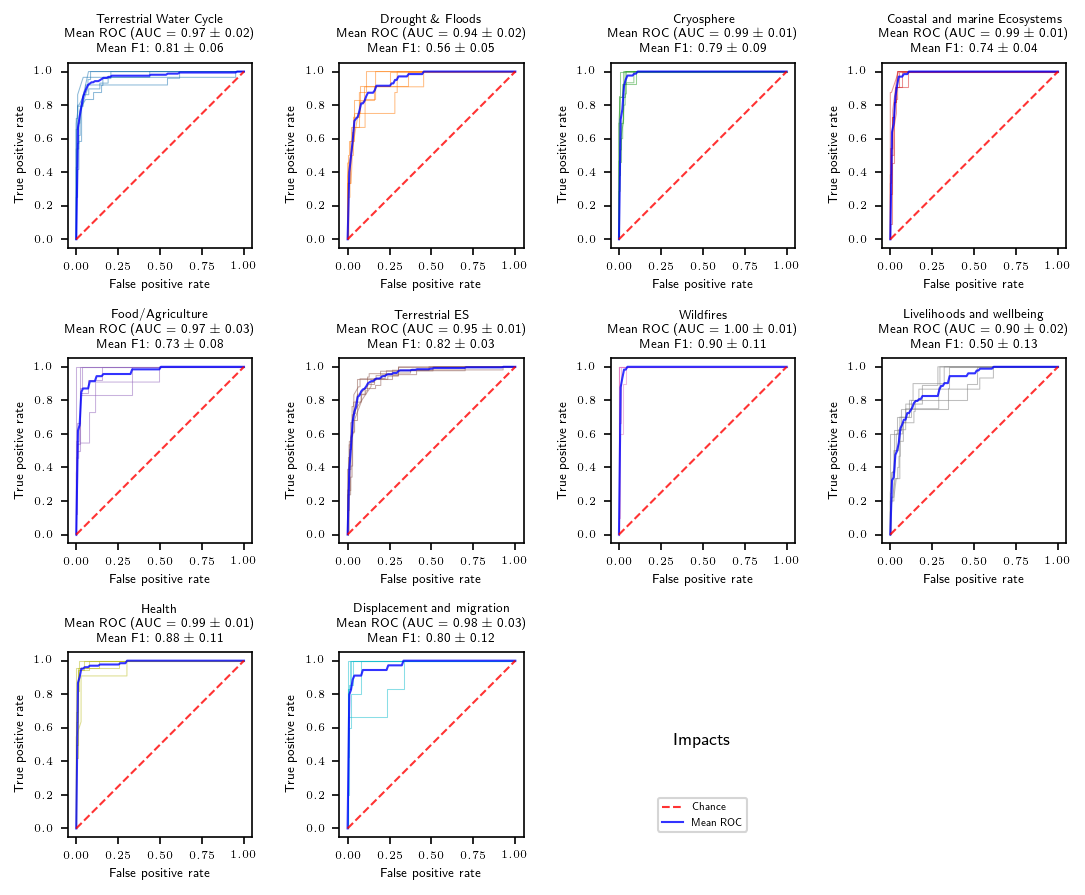

In [140]:
from scipy import interp
import matplotlib.gridspec as gridspec

model = multimodels_specific_impacts[0]

fig = plt.figure(dpi=150,figsize=(7.2,7.2), constrained_layout=True)

ncols = 4

gs = gridspec.GridSpec(4, ncols, figure=fig)

for j,c in enumerate(specific_impacts):
    ax = plt.subplot(gs[j//ncols,j%ncols])
    mean_roc_auc_plot(model, c, ax)
    
j+=1
ax = plt.subplot(gs[j//ncols,j%ncols])
blank_roc_auc_plot(ax, "Impacts")
    
            
plt.savefig('../figures/si_figure_3.pdf', bbox_inches="tight")
plt.savefig('../figures/si_figure_3.png', bbox_inches="tight")